# Andrzej Olszyna
# OCR - rozpoznawanie znaków oparte na modelu klasyfikacyjnym
### Celem projektu jest zbudowanie klasyfikatora rozpoznającego znaki z obrazów
Do budowy modelu zostal wykorzystany zbiór obrazów wygenerowanych w oparciu o zestaw 65 000 różnych czcionek systemowych.

# 1. Generowanie zbioru uczącego

In [ ]:
import string
from PIL import Image, ImageFont
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os, sys
from fnmatch import fnmatch
import csv

#### Wygenerowanie podstawowych znaków (string.ascii_letters+string.digits) dostępnych dla poszczególnych czcionek i zapisanie ich jako obraz o rozmiarze 20/20 px z labelem znaku jako nazwa pliku

In [ ]:

root = "/media/andrzej/d9dadc48-a6be-400f-9655-c4ae472d9abe/andrzej/font_unrar"
point_size = 25
pattern = "*tf"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            try:
                working_path =  os.path.join(path, name)
                export_path = root+'/unpack/'+name[:-4]+'/'
                os.makedirs(export_path, exist_ok=True)
                font = ImageFont.truetype(working_path, point_size)
                for char in string.ascii_letters+string.digits:
                    im = Image.Image()._new(font.getmask(char))
                    imResize = im.resize((20,20), Image.ANTIALIAS)
                    imResize.save(export_path+char + ".bmp", quality=90)
            except:
                print(name)
       

#### zapis danych z obrazów do pliku csv w strukturze 1 wiersz - 1 obraz

In [ ]:

root = "/media/andrzej/d9dadc48-a6be-400f-9655-c4ae472d9abe/andrzej/font_unrar/unpack"
export_tab = []
i = 0     
        
with open('font_data.csv', "a") as output:
    writer = csv.writer(output, lineterminator='\n')  
    
    for path, subdirs, files in os.walk(root):
        export_tab = []
        i+=1  
        print(i)
        for name in files:
            try:
                working_path =  os.path.join(path, name)
                np_im = np.array(Image.open(working_path))
                array_im = np_im.reshape(1,400)
                array_label= np.append(array_im,name[:-4]) 
                export_tab.append(array_label)                
            except Exception as e:
                print(str(e))
                
        writer.writerows(export_tab)   

# 2. Analiza oraz obróbka danych na potrzeby modelu
### Do obróbki danych oraz budowy modelu wykorzystana została platforma Google Colab. Mimo wszystko ze względu na ograniczenia wydajnościowe zbiór wejściowy został ograniczony do 100 000 obrazów 


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [0]:
df2=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/font_data_sample.csv',header=None,sep = ';', skiprows = 1)

In [0]:
df2.shape

(99999, 402)

In [0]:
df_sample = df2.sample(10)
df_sample.shape

(10, 402)

## Wizualizacja losowych 20 obrazów

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


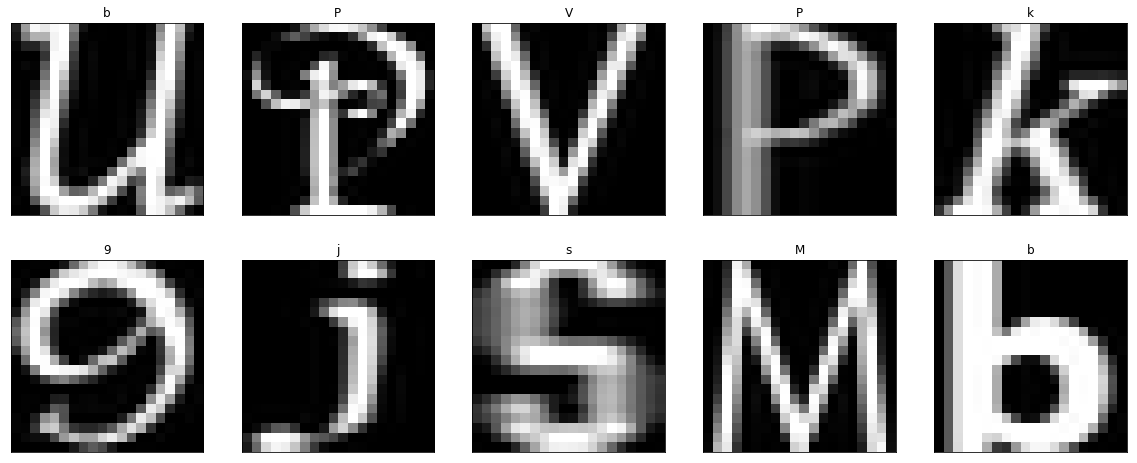

In [0]:
array = (df_sample[df_sample.columns[1:401]]).as_matrix().reshape(10,20,20)
titles = list(df_sample[df_sample.columns[-1]][1:])

plt.figure(figsize=(20,8))
for i in range(len(array)):    
    plt.subplot(2,5,i+1), plt.imshow(array[i] ,'gray')    
    plt.title(str(titles[i-1]))
    plt.xticks([]),plt.yticks([])
plt.show()


## Porównanie metod wygładzania krawędzi - biblioteka OpenCV

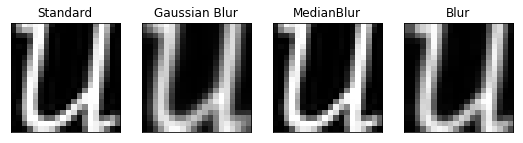

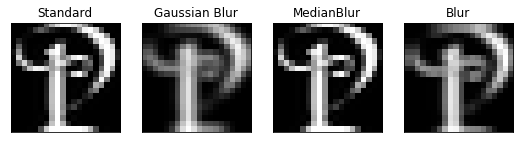

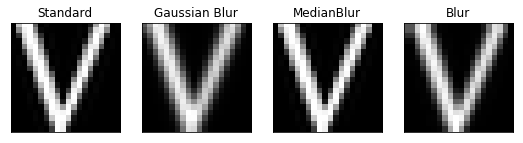

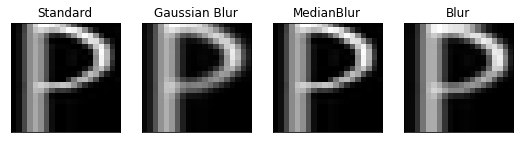

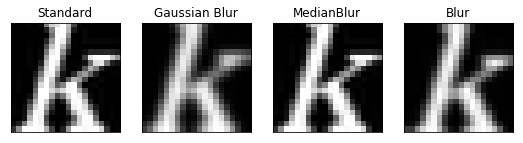

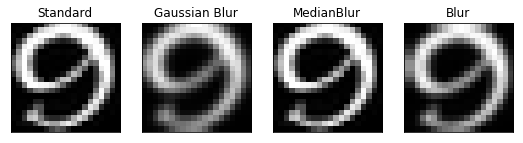

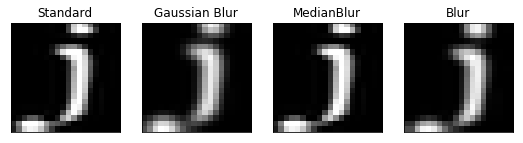

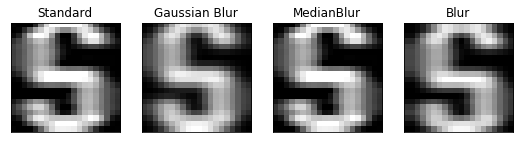

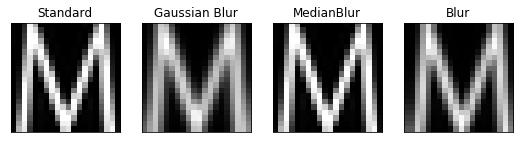

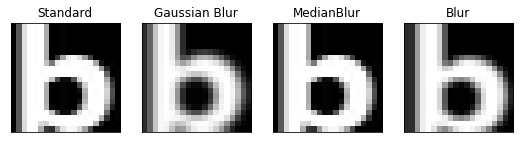

In [0]:
titles = ['Standard', 'Gaussian Blur','MedianBlur', 'Blur']

for letter in array:
    img = np.float32(letter)
    img_blur1 = cv2.GaussianBlur(img, (3, 3), 0)
    img_blur2 = cv2.medianBlur(img, 1)
    img_blur3 = cv2.blur(img,(2,2)) 
    images = [img,img_blur1, img_blur2, img_blur3]

    plt.figure(figsize=(9,9))
    for i in range(4):
        plt.subplot(1,4,i+1),plt.imshow(images[i],'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])

    plt.show()

### Wybór padł na podstawową metodę blur() uśredniającą wartość pikseli z macierzy 2x2

In [0]:
img = np.float32(array[7])
img_blur = cv2.blur(np.float32(array[7]),(2,2))


### Binaryzacja obrazów przy użyciu metod thresholdingu biblioteki OpenCV
Porównanie wybranych metod

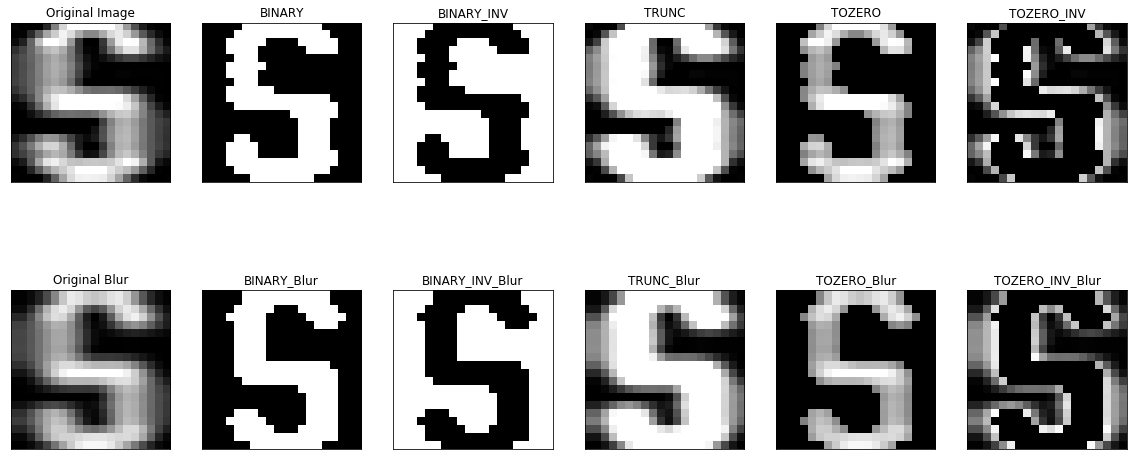

In [0]:
ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)
ret,thresh6 = cv2.threshold(img_blur,127,255,cv2.THRESH_BINARY)
ret,thresh7 = cv2.threshold(img_blur,127,255,cv2.THRESH_BINARY_INV)
ret,thresh8 = cv2.threshold(img_blur,127,255,cv2.THRESH_TRUNC)
ret,thresh9 = cv2.threshold(img_blur,127,255,cv2.THRESH_TOZERO)
ret,thresh10 = cv2.threshold(img_blur,127,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV','Original Blur','BINARY_Blur','BINARY_INV_Blur','TRUNC_Blur','TOZERO_Blur','TOZERO_INV_Blur']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5,img_blur, thresh6, thresh7, thresh8, thresh9, thresh10]

plt.figure(figsize=(20,9))
for i in range(12):
    plt.subplot(2,6,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

### Porównanie znaków przed i po przekształceniu

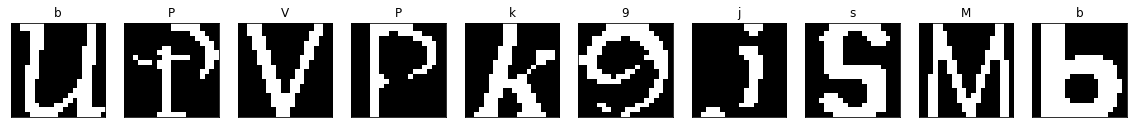

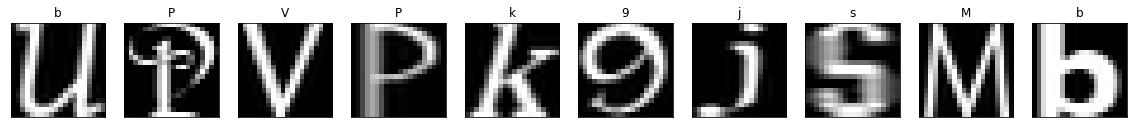

In [0]:
titles = list(df_sample[df_sample.columns[-1]][1:])
array_clear = []
for image in array:
    img_blur = cv2.blur(np.float32(image),(2,2))
    _, img_out = cv2.threshold(img_blur,127,255,cv2.THRESH_BINARY)
    array_clear.append(img_out)

    
plt.figure(figsize=(20,10))
for i in range(len(array_clear)):    
    plt.subplot(1,10,i+1), plt.imshow(array_clear[i] ,'gray')    
    plt.title(str(titles[i-1]))
    plt.xticks([]),plt.yticks([])

plt.show()

plt.figure(figsize=(20,10))
for i in range(len(array)):    
    plt.subplot(1,10,i+1), plt.imshow(array[i] ,'gray')    
    plt.title(str(titles[i-1]))
    plt.xticks([]),plt.yticks([])

plt.show()

In [ ]:
df_array = (df2[df2.columns[1:401]]).as_matrix().reshape(len(df2),20,20)

### Zastosowanie filtrów dla całego zbioru

In [0]:
list_clear = []

for letter in df_array:
    img_blur = cv2.blur(np.float32(letter),(2,2))
    _, img_out = cv2.threshold(img_blur,127,255,cv2.THRESH_BINARY)
    list_clear.append(img_out)

array_clear = np.array(list_clear)

In [0]:
labels = df2[df2.columns[-1]][0:]
array_df = array_clear.reshape(len(array_clear),400)
df_clear = pd.DataFrame(array_df)
df_clear['label'] = labels

### Pobranie wzorcowego zbioru znaków czcionki Arial oraz użycie takiego samego preprocessu

In [0]:
df_arial=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Arial_sample_.csv',header=None,sep = ';', skiprows = 1)


In [0]:
unique_labels = list(df_arial[df_arial.columns[-1]][0:])

In [ ]:
arial = (df_arial[df_arial.columns[1:401]]).as_matrix().reshape(len(df_arial),20,20)
titles_arial = df_arial[df_arial.columns[-1]][1:]
arial_clear = []
for image in arial:
    img_blur = cv2.blur(np.float32(image),(2,2))
    _, img_out = cv2.threshold(img_blur,127,255,cv2.THRESH_BINARY)
    arial_clear.append(img_out)

np_arial_clear = np.array(arial_clear)
arial_reshape = np_arial_clear.reshape(len(np_arial_clear),400)
df_arial_clear = pd.DataFrame(arial_reshape)
df_arial_clear['label'] = titles_arial


### Wybór jednej klasy do celów dostosowania miar podobieństwa obrazów

In [ ]:
df_arial_test = df_arial_clear[df_arial_clear.iloc[:, -1]  == 'A']
df_arial_test = df_arial_test[df_arial_test.columns[0:400]]
df_test = df_clear[df_clear.iloc[:, -1]  == 'A']
df_test = df_test[df_test.columns[0:400]]
a,_ = df_test.shape
array_arial_test = df_arial_test.as_matrix().reshape(20,20)
images_arial_test = np.float32(array_arial_test)
array_test = df_test.as_matrix().reshape(a,20,20)
images_test = np.float32(array_test)
  

## Test miar podobieństwa obrazów na wybranej literze 'A'
Metoda i punkt odcięcia nieporządanych obrazów zostały wybrane na zasadzie porównania i wizualizacji wybranej klasy. Ideą tego zabiegu było wyeliminowanie liter z futurystycznych i nieczytelnych czcionek. 

Wzór litery - arial


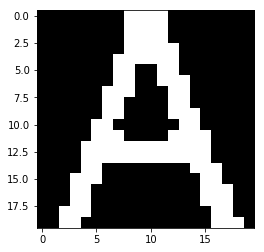

Przykladowe 50 zdjec


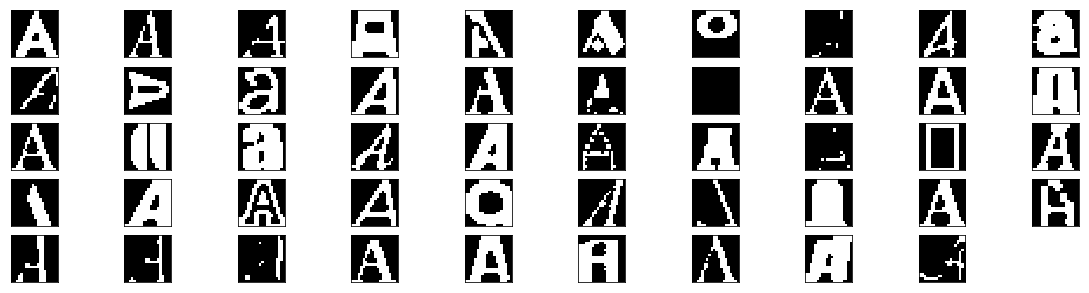

Wybrane zdjęcia wg miary podobieństwa:


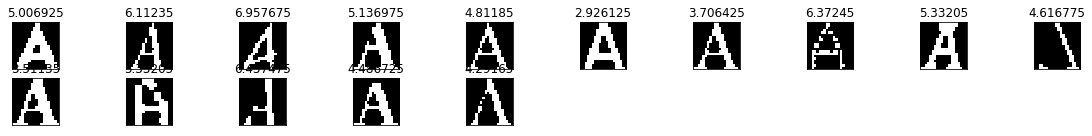

In [0]:
print('Wzór litery - arial')

plt.imshow(images_arial_test, 'gray')
plt.show()

print('Przykladowe 50 zdjec')

plt.figure(figsize=(20,5))
for i in range(len(images_test[1:50])):  
    plt.subplot(5,10,i+1), plt.imshow(images_test[i] ,'gray')   
    plt.xticks([]),plt.yticks([])
plt.show()

print('Wybrane zdjęcia wg miary podobieństwa:')


j=0
plt.figure(figsize=(20,5))
for i in range(len(images_test[1:50])):    
    res = cv2.matchTemplate(images_test[i],images_arial_test,cv2.TM_SQDIFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    #print(max_val/1000000)

    if min_val/1000000 <7:
        j += 1
        plt.subplot(5,10,j), plt.imshow(images_test[i] ,'gray')   
        plt.title(str(min_val/1000000))
        plt.xticks([]),plt.yticks([])

plt.show()

### Zastosowanie transformacji dla całego zbioru

In [ ]:
filter_list = []

for letter in unique_labels:
#   print(letter)
    df_arial_letter = df_arial[df_arial.iloc[:, -1]  == letter]
    df_arial_letter = df_arial_letter[df_arial_letter.columns[1:401]]
    df_letter = df_clear[df_clear.iloc[:, -1]  == letter]
    df_letter = df_letter[df_letter.columns[0:400]]
    a,_ = df_letter.shape
    array_arial_letter = df_arial_letter.as_matrix().reshape(20,20)
    images_arial_letter = np.float32(array_arial_letter)
    array_letter = df_letter.as_matrix().reshape(a,20,20)
    images_letter = np.float32(array_letter)

    # filtr miarą podobieństwa
    for i in range(len(images_letter)):    
    res = cv2.matchTemplate(images_letter[i],images_arial_letter,cv2.TM_SQDIFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    if min_val/1000000 <7:
        _temp = images_letter[i].reshape(400)
        _temp = np.append(_temp,letter)
        filter_list.append(_temp)
        


In [0]:
df_filter = pd.DataFrame(filter_list)
df_filter.shape

(58111, 401)

### Liczebność pozostalych klas


In [0]:

print(df_filter[df_filter.columns[-1]].value_counts())

T    1353
i    1319
Y    1300
1    1267
7    1242
3    1238
I    1219
X    1190
j    1172
V    1171
v    1168
y    1158
t    1139
f    1126
2    1120
r    1115
4    1112
x    1108
C    1098
Z    1085
l    1069
A    1044
U    1034
L    1034
c    1033
O    1030
J    1029
S    1009
s    1005
o     999
     ... 
0     973
k     946
p     927
P     901
u     875
8     866
h     858
5     853
9     847
q     843
d     819
G     797
H     785
e     777
D     776
b     746
6     736
Q     705
a     686
N     686
n     680
E     667
K     659
w     598
W     572
B     570
m     549
R     491
g     482
M     482
Name: 400, Length: 62, dtype: int64


### Wizualizacja pierwszych 20 obrazów z każdej klasy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


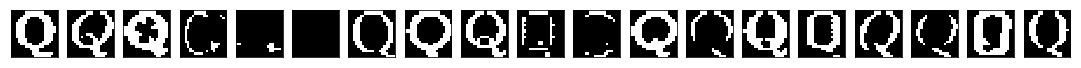

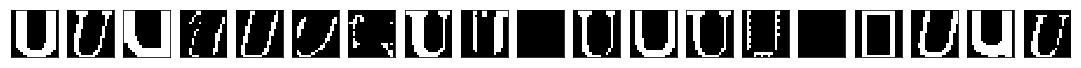

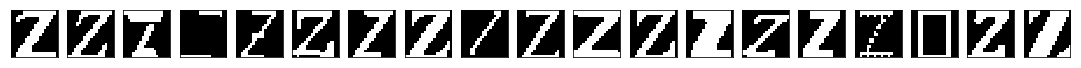

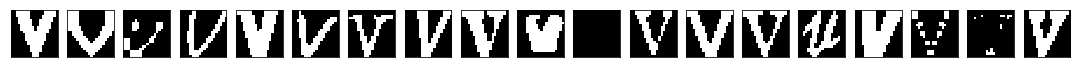

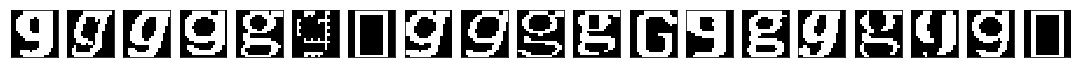

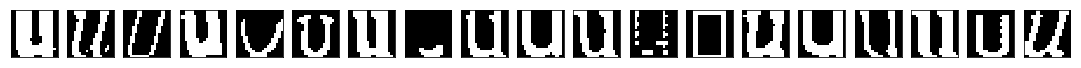

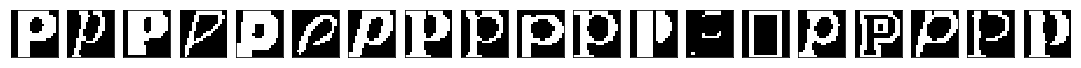

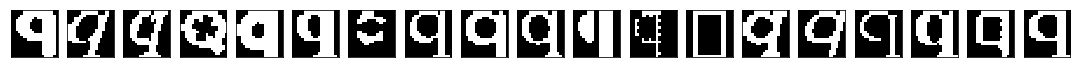

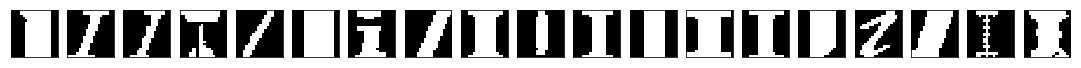

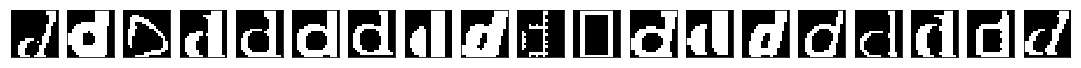

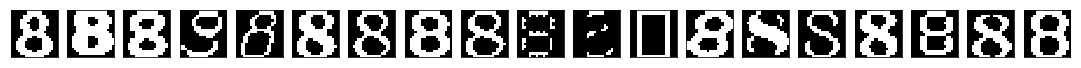

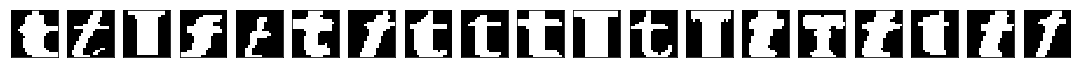

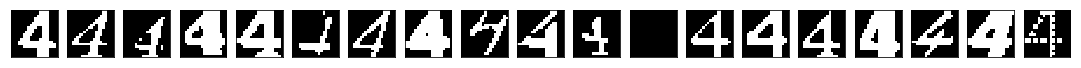

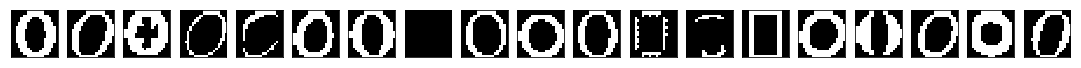

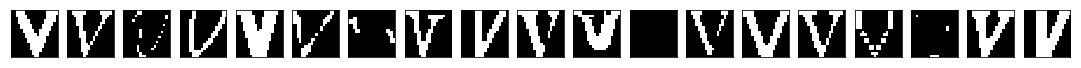

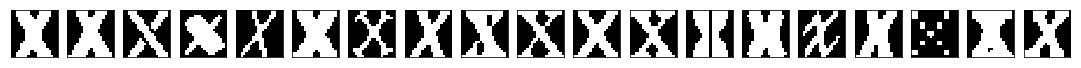

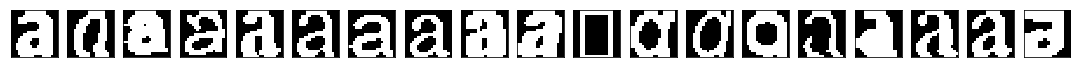

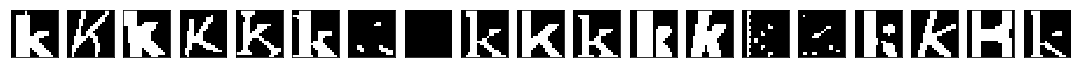

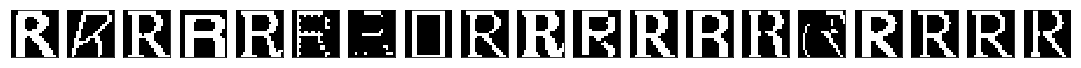

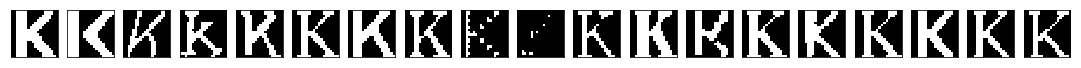

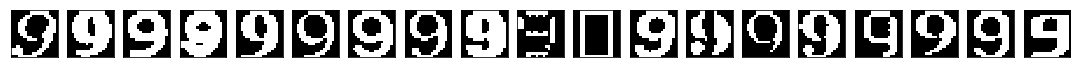

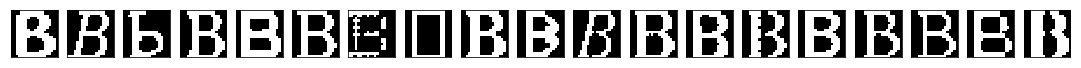

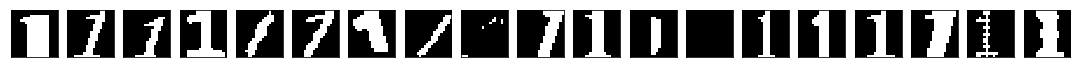

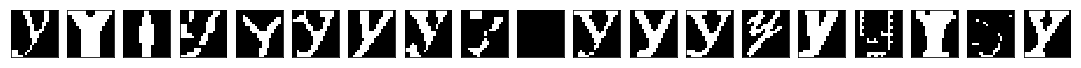

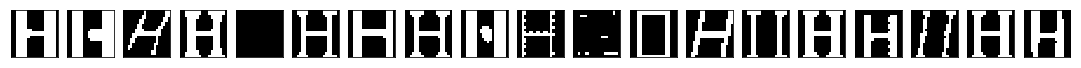

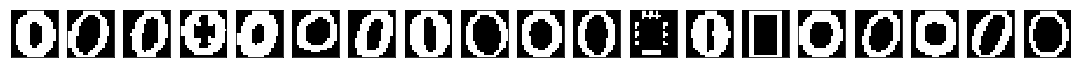

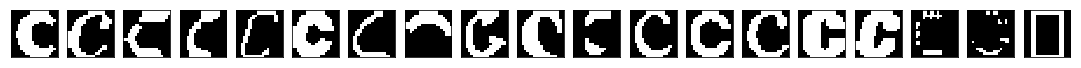

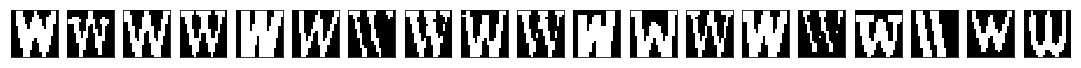

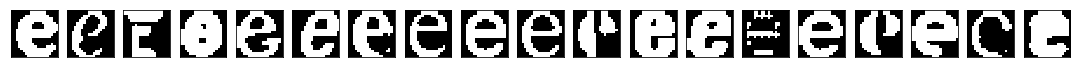

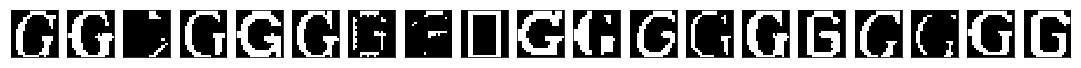

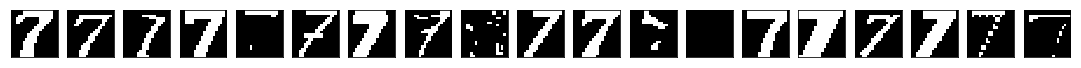

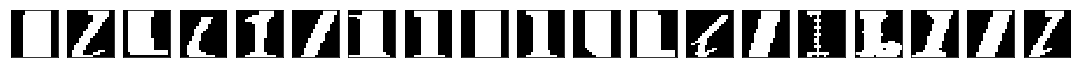

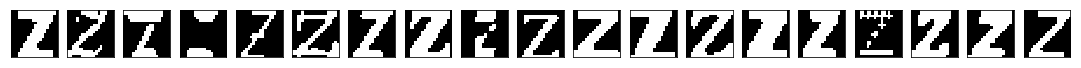

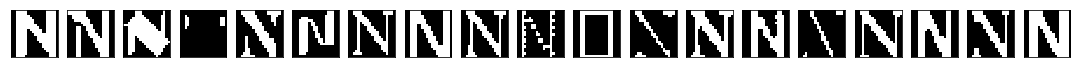

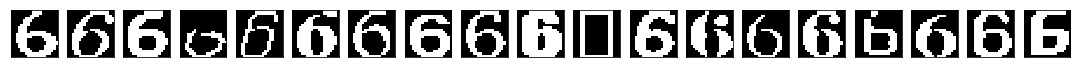

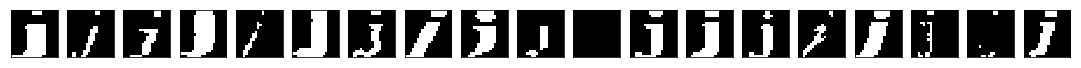

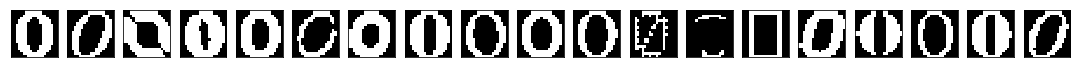

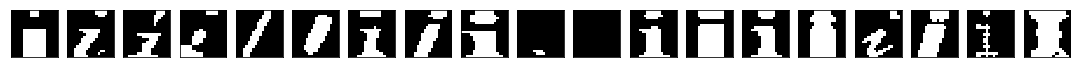

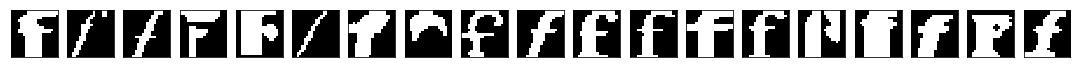

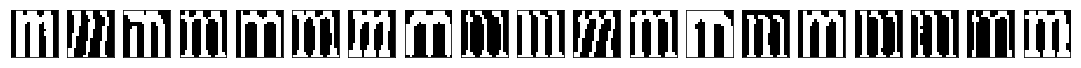

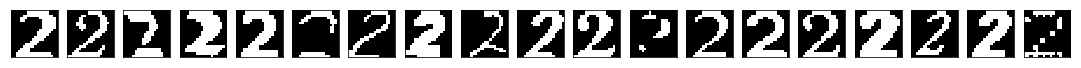

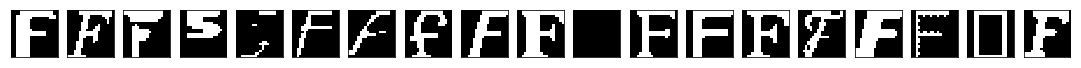

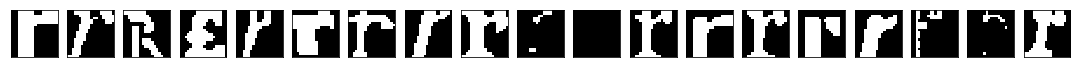

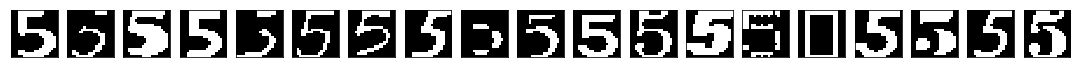

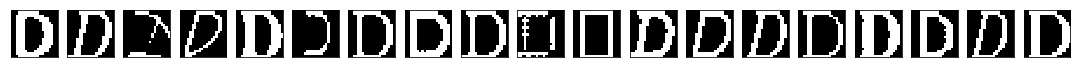

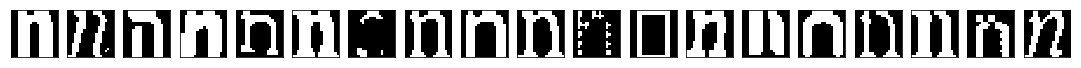

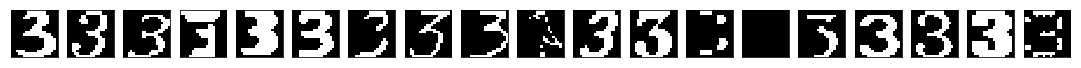

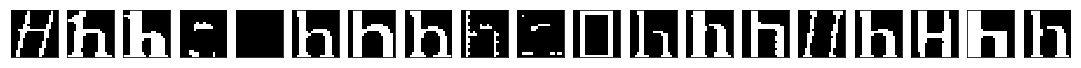

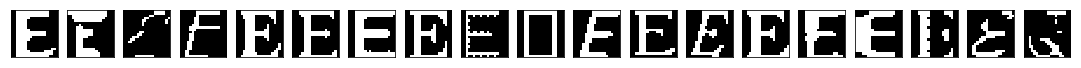

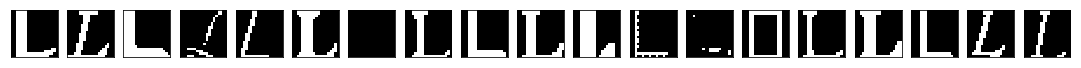

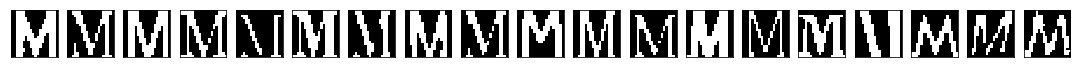

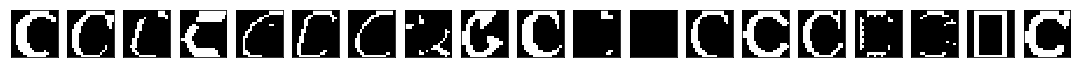

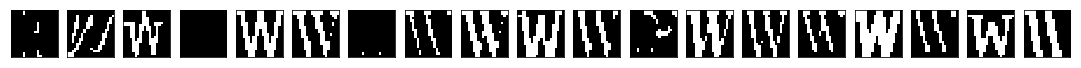

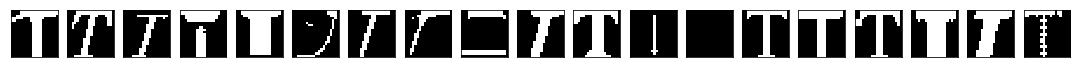

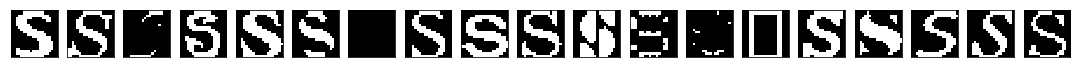

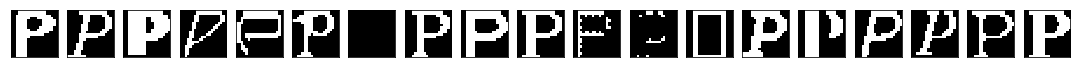

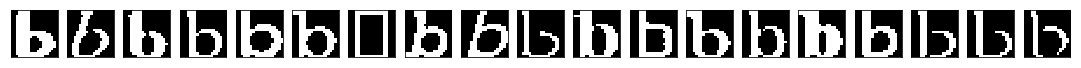

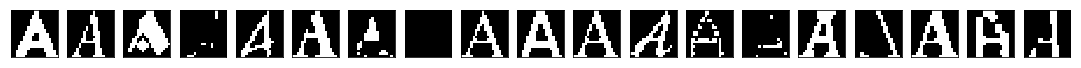

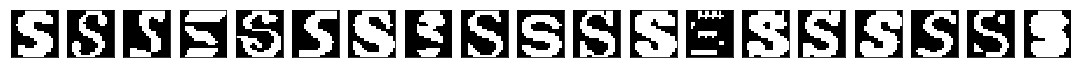

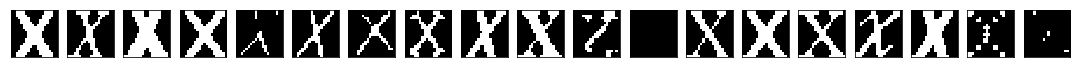

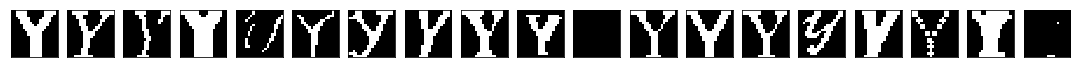

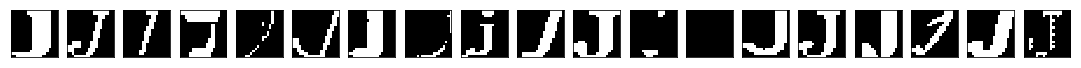

In [0]:
for letter in unique_labels: 
    _df = df_filter[df_filter.iloc[:, -1]  == letter]
    _df = _df[_df.columns[0:400]]
    a,_ = _df.shape
    _array = _df.as_matrix().reshape(a,20,20)
    _array = np.float32(_array)
    plt.figure(figsize=(20,10))
    for i in range(len(_array[1:20])):    
    plt.subplot(1,20,i+1), plt.imshow(_array[i] ,'gray')    
    plt.xticks([]),plt.yticks([])
    plt.show()


### Ze względów wydajnościowych i konieczności przetwarzania całego zbioru od początu, dane zostały zapisane do pliku

In [0]:
df_filter.to_csv('clean_dataset.csv')

In [ ]:
!cp clean_dataset.csv "/content/gdrive/My Drive/Colab Notebooks/"
!ls "/content/gdrive/My Drive/Colab Notebooks/"

In [4]:
df_filter=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/clean_dataset.csv')
df_filter  = df_filter.drop(df_filter.columns[0], axis=1)
print(df_filter.shape)
print(df_filter.head(5))

(58111, 401)
     0    1    2    3    4    5      6  ...    394    395    396  397  398  399  400
0  0.0  0.0  0.0  0.0  0.0  0.0  255.0  ...  255.0  255.0  255.0  0.0  0.0  0.0    Q
1  0.0  0.0  0.0  0.0  0.0  0.0    0.0  ...  255.0  255.0    0.0  0.0  0.0  0.0    Q
2  0.0  0.0  0.0  0.0  0.0  0.0    0.0  ...  255.0  255.0    0.0  0.0  0.0  0.0    Q
3  0.0  0.0  0.0  0.0  0.0  0.0  255.0  ...    0.0    0.0    0.0  0.0  0.0  0.0    Q
4  0.0  0.0  0.0  0.0  0.0  0.0    0.0  ...    0.0    0.0    0.0  0.0  0.0  0.0    Q

[5 rows x 401 columns]


### Dodatkowe usunięcie całych czarnych obrazów

In [5]:
#usuń wiersze z samymi zerami
df_filter_binary = df_filter.loc[(df_filter[df_filter.columns[:-1]]!=0).any(axis=1)]
print(df_filter_binary.shape)
print(df_filter_binary.head(5))

(56471, 401)
     0    1    2    3    4    5      6  ...    394    395    396  397  398  399  400
0  0.0  0.0  0.0  0.0  0.0  0.0  255.0  ...  255.0  255.0  255.0  0.0  0.0  0.0    Q
1  0.0  0.0  0.0  0.0  0.0  0.0    0.0  ...  255.0  255.0    0.0  0.0  0.0  0.0    Q
2  0.0  0.0  0.0  0.0  0.0  0.0    0.0  ...  255.0  255.0    0.0  0.0  0.0  0.0    Q
3  0.0  0.0  0.0  0.0  0.0  0.0  255.0  ...    0.0    0.0    0.0  0.0  0.0  0.0    Q
4  0.0  0.0  0.0  0.0  0.0  0.0    0.0  ...    0.0    0.0    0.0  0.0  0.0  0.0    Q

[5 rows x 401 columns]


### Transformacja danych do postaci binarnej

In [0]:
X = df_filter_binary.drop(df_filter_binary.columns[-1],1)
y = df_filter_binary[df_filter_binary.columns[-1]]

In [7]:
X = (X.astype(float)).astype(int).replace(255, 1)
X.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399
0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0
1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0
2,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
3,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
7,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0
8,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0
9,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
10,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0


### Podział zbioru na uczący i testowy

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size= 0.2)


# 3. Redukcji wymiarowości - metoda PCA

In [0]:
pca = PCA()
X_train_test = pca.fit_transform(X_train)
X_test_test = pca.transform(X_test)

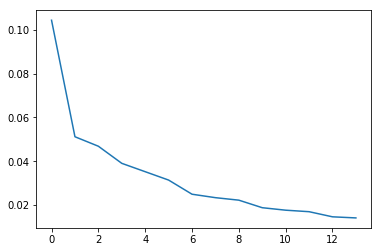

In [0]:
explained_var = pca.explained_variance_ratio_
plt.plot(explained_var[1:15])

### Testy modeli na 6 zmiennych

In [0]:
pca = PCA(n_components= 6)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# 4. Wybór modelu statystycznego

### Grid search modeli i parametrów
Wybrane zostały najpopularniejsze i poznane na zajęciach klasyfikatory przeznaczone do uczenia nadzorowanego.
Przygotowany grid search miał wyłonić na podstawie skuteczności najlepszą metodą oraz jej optymalne parametry.
Niestety ze względu na ograniczenia sprzętowe, na analizowanym zbiorze danych nie wykonał się w całości za jednym uruchomieniem. Podzielony został na kilka fragmentów aby wyłonić najskuteczniejszy model.

In [0]:
names = ["Naiv","Tree","MaxAbs","SVM","Bagg","Las"]

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, max_features= 0.5, max_samples=0.5, bootstrap= False)

models = [[("model", MultinomialNB())],
         [("model", DecisionTreeClassifier())],
         [("scaler", MaxAbsScaler()), ("model", LogisticRegression())],
         [("scaler", MaxAbsScaler()), ("model", SVC())],
         [("model", BaggingClassifier())],
         [("model", RandomForestClassifier())]]
    

param_grids = [{"model__alpha": [0.1, 1, 10], "model__fit_prior": [False, True]},
               {"model__criterion": ["gini", "entropy"], "model__min_samples_split": [2, 10, 100], "model__max_depth": [None, 10, 100, 200]}, 
               {"model__penalty": ["l1", "l2"], "model__C": [0.1, 1, 10]},
               [{"model__kernel": ["rbf"], "model__gamma": [0.1, 1]},{"model__kernel": ["poly"], "model__degree": [2, 3]}],
               {"model__base_estimator": [DecisionTreeClassifier()] , "model__n_estimators": [50, 100, 300],
                "model__max_features": [0.5], "model__max_samples": [0.5], "model__bootstrap": [False]},
               {"model__n_estimators": [50, 100, 300],"model__bootstrap": [False],"model__max_depth": [None, 10, 100, 200],"model__criterion": ["gini", "entropy"]}
              ]

uses = [False,False,False,True,True,False]


### RandomForestClassifier

In [0]:
best_models = []
names_print = []
for act, name ,pipe, params in zip(uses,names, models, param_grids):
    if act == True:        
        print(f"Trenuje model: {name}")
        pipeline = Pipeline(pipe)
        gs = GridSearchCV(estimator=pipeline, param_grid=params)
        gs.fit(X_train_pca, y_train)
        for mean, std, param in zip(gs.cv_results_["mean_test_score"], gs.cv_results_["std_test_score"], gs.cv_results_["params"]):
            print(f"{param}: mean:{mean} , std:{std}")
        best_models.append(gs.best_estimator_)
        names_print.append(name)

Trenuje model: Las


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'model__bootstrap': False, 'model__criterion': 'gini', 'model__max_depth': None, 'model__n_estimators': 50}: mean:0.5175959387368784 , std:0.0029278709009516904
{'model__bootstrap': False, 'model__criterion': 'gini', 'model__max_depth': None, 'model__n_estimators': 100}: mean:0.5214248838409912 , std:0.003717841885447751
{'model__bootstrap': False, 'model__criterion': 'gini', 'model__max_depth': None, 'model__n_estimators': 300}: mean:0.5256410256410257 , std:0.0039037762390179186
{'model__bootstrap': False, 'model__criterion': 'gini', 'model__max_depth': 10, 'model__n_estimators': 50}: mean:0.48698588883152644 , std:0.005201172409131786
{'model__bootstrap': False, 'model__criterion': 'gini', 'model__max_depth': 10, 'model__n_estimators': 100}: mean:0.4890939597315436 , std:0.0028177688086737517
{'model__bootstrap': False, 'model__criterion': 'gini', 'model__max_depth': 10, 'model__n_estimators': 300}: mean:0.492643262777491 , std:0.004645786056648081
{'model__bootstrap': False, 'mode

In [0]:
for act ,name, best_model in zip(uses,names_print,best_models):
    print(best_model)    
    print(f" {name}: {accuracy_score(best_model.predict(X_test_pca), y_test)}")

Pipeline(memory=None,
         steps=[('model',
                 RandomForestClassifier(bootstrap=False, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=300, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)
 Las: 0.5386733201410996


### BaggingClassifier z estymatorem drzewa decyzyjnego

In [0]:
#bagging na RandomTreeClassifier
names = ["Bagging"]
models = [("model", BaggingClassifier())]
param_grids = [{"model__base_estimator": [DecisionTreeClassifier()] ,"model__n_estimators": [50, 100, 300], 
                "model__max_features": [0.5], "model__max_samples": [0.5], "model__bootstrap": [False]}]
 

In [0]:
best_models = []
names_print = []
for act, name ,pipe, params in zip(uses,names, models, param_grids):
    if act == True:        
        print(f"Trenuje model: {name}")
        pipeline = Pipeline(pipe)
        gs = GridSearchCV(estimator=pipeline, param_grid=params)
        gs.fit(X_train_pca, y_train)
        for mean, std, param in zip(gs.cv_results_["mean_test_score"], gs.cv_results_["std_test_score"], gs.cv_results_["params"]):
            print(f"{param}: mean:{mean} , std:{std}")
        best_models.append(gs.best_estimator_)
        names_print.append(name)

Trenuje model: Bagg


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'model__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), 'model__bootstrap': False, 'model__max_features': 0.5, 'model__max_samples': 0.5, 'model__n_estimators': 50}: mean:0.3857124419204956 , std:0.005287061576403146
{'model__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state

### Support Vector Machine

In [0]:
best_models = []
names_print = []
for act, name ,pipe, params in zip(uses,names, models, param_grids):
    if act == True:        
        print(f"Trenuje model: {name}")
        pipeline = Pipeline(pipe)
        gs = GridSearchCV(estimator=pipeline, param_grid=params)
        gs.fit(X_train_pca, y_train)
        for mean, std, param in zip(gs.cv_results_["mean_test_score"], gs.cv_results_["std_test_score"], gs.cv_results_["params"]):
            print(f"{param}: mean:{mean} , std:{std}")
        best_models.append(gs.best_estimator_)
        names_print.append(name)

Trenuje model: SVM


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in v

{'model__gamma': 0.1, 'model__kernel': 'rbf'}: mean:0.4732404061263122 , std:0.001886558719032826
{'model__gamma': 1, 'model__kernel': 'rbf'}: mean:0.5270177250043022 , std:0.002648629249195532
{'model__degree': 2, 'model__kernel': 'poly'}: mean:0.2819437274135261 , std:0.002549633748711912
{'model__degree': 3, 'model__kernel': 'poly'}: mean:0.06732920323524351 , std:0.0021390114883918857


### Drzewo decyzyjne

In [0]:
names = ["Tree","MaxAbs","SVM","Bagg","Las"]

models = [[("model", DecisionTreeClassifier())],
         [("scaler", MaxAbsScaler()), ("model", LogisticRegression())],
         [("scaler", MaxAbsScaler()), ("model", SVC())],
         [("model", BaggingClassifier())],
         [("model", RandomForestClassifier())]]
    
param_grids = [{"model__criterion": ["gini", "entropy"], "model__min_samples_split": [2, 10, 50], "model__max_depth": [None, 100, 200]}, 
               {"model__penalty": ["l1", "l2"], "model__C": [0.1, 1, 10]},
               [{"model__kernel": ["rbf"], "model__gamma": [0.1, 1, 1.5, 2]}],
               {"model__base_estimator": [DecisionTreeClassifier()] , "model__n_estimators": [200, 300],
                "model__max_features": [0.5], "model__max_samples": [0.5], "model__bootstrap": [False]},
               {"model__n_estimators": [200,300],"model__bootstrap": [False],"model__max_depth": [None, 200],"model__criterion": ["gini", "entropy"]}
              ]

uses = [True,True,True,True,True]

In [0]:
best_models = []
names_print = []
for act, name ,pipe, params in zip(uses,names, models, param_grids):
    if act == True:        
        print(f"Trenuje model: {name}")
        pipeline = Pipeline(pipe)
        gs = GridSearchCV(estimator=pipeline, param_grid=params)
        gs.fit(X_train_pca, y_train)
        for mean, std, param in zip(gs.cv_results_["mean_test_score"], gs.cv_results_["std_test_score"], gs.cv_results_["params"]):
            print(f"{param}: mean:{mean} , std:{std}")
        best_models.append(gs.best_estimator_)
        names_print.append(name)

Trenuje model: Tree


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_split': 2}: mean:0.39679056960936154 , std:0.0017300892550180247
{'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_split': 10}: mean:0.4055455171226983 , std:0.002449031215908738
{'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_split': 50}: mean:0.40926690758905526 , std:0.0036089836217196476
{'model__criterion': 'gini', 'model__max_depth': 100, 'model__min_samples_split': 2}: mean:0.3990707279297883 , std:0.0013951825003824113
{'model__criterion': 'gini', 'model__max_depth': 100, 'model__min_samples_split': 10}: mean:0.40509378764412324 , std:0.0027576433304084534
{'model__criterion': 'gini', 'model__max_depth': 100, 'model__min_samples_split': 50}: mean:0.40935295129926 , std:0.003661325504866839
{'model__criterion': 'gini', 'model__max_depth': 200, 'model__min_samples_split': 2}: mean:0.39790913784202375 , std:0.0019453034418434507
{'model__criterion': 'gini'

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_clas

{'model__C': 0.1, 'model__penalty': 'l1'}: mean:0.4003183617277577 , std:0.005874341651162955
{'model__C': 0.1, 'model__penalty': 'l2'}: mean:0.3777533987265531 , std:0.003786054660870184
{'model__C': 1, 'model__penalty': 'l1'}: mean:0.41156857683703324 , std:0.0048908262553961565
{'model__C': 1, 'model__penalty': 'l2'}: mean:0.4087936671829289 , std:0.004661363701312782
{'model__C': 10, 'model__penalty': 'l1'}: mean:0.41264412321459304 , std:0.004693867434438571
{'model__C': 10, 'model__penalty': 'l2'}: mean:0.41208483909826193 , std:0.0046429043742918725
Trenuje model: SVM


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'model__gamma': 0.1, 'model__kernel': 'rbf'}: mean:0.4732404061263122 , std:0.001886558719032826
{'model__gamma': 1, 'model__kernel': 'rbf'}: mean:0.5270177250043022 , std:0.002648629249195532
{'model__gamma': 1.5, 'model__kernel': 'rbf'}: mean:0.5348692135604888 , std:0.002152537033121444
{'model__gamma': 2, 'model__kernel': 'rbf'}: mean:0.5383970056788848 , std:0.002516682508393348
Trenuje model: Bagg


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'model__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), 'model__bootstrap': False, 'model__max_features': 0.5, 'model__max_samples': 0.5, 'model__n_estimators': 200}: mean:0.424604198933058 , std:0.0030695158696897465
{'model__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_stat

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


### RandomForestClassifier oraz SVM
Najlepsze rezultaty zostały uzyskane metodą lasów losowych oraz maszyną wektorów nośnych.
Na tej podstawie został przeprowadzony jeszcze jeden grid search, testujący wybrane metody również na różnej ilości zmiennych wybranych w algorytmie PCA

In [0]:
pca_val = [4,5,6,7,8]
for val in pca_val:
    pca = PCA(n_components= val)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    #SVM
    svm_model = SVC(gamma=2, kernel = 'rbf')
    svm_model.fit(X_train_pca, y_train)
    y_pred = svm_model.predict(X_test_pca)
    accuracy_svm = accuracy_score(y_test, y_pred)
    print(f'PCA_component: {val}, accuracy svm : {str(accuracy_svm)}')
    #Random Forest
    rf_model = RandomForestClassifier(bootstrap=False, 
                                        criterion='gini', 
                                        max_features='auto',                                   
                                        min_samples_leaf=1, 
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=300)
    rf_model.fit(X_train_pca,y_train)
    y_pred = rf_model.predict(X_test_pca)
    accuracy_rf = accuracy_score(y_test, y_pred)
    print(f'PCA_component: {val}, accuracy Random Forest : {str(accuracy_rf)}')
  
  

PCA_component: 4, accuracy svm : 0.36848162903939796
PCA_component: 4, accuracy Random Forest : 0.3455511288180611
PCA_component: 5, accuracy svm : 0.4444444444444444
PCA_component: 5, accuracy Random Forest : 0.44833997343957505
PCA_component: 6, accuracy svm : 0.4816290393979637
PCA_component: 6, accuracy Random Forest : 0.5491810535635236
PCA_component: 7, accuracy svm : 0.4440017706949978
PCA_component: 7, accuracy Random Forest : 0.5876051350154936
PCA_component: 8, accuracy svm : 0.39194333776007084
PCA_component: 8, accuracy Random Forest : 0.613368747233289


### Lasy losowe - optymalny klasyfikator dla analizowanego zagadnienia
Finalny wybór padł na lasy losowe. Ze względów wydajnościowych liczba zmiennych została ograniczona do 7.

In [10]:
pca = PCA(n_components= 7)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
rf_model = RandomForestClassifier(bootstrap=False, 
                                        criterion='gini', 
                                        max_features='auto',                                   
                                        min_samples_leaf=1, 
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=300)
rf_model.fit(X_train_pca,y_train)
y_pred = rf_model.predict(X_test_pca)
accuracy_rf = accuracy_score(y_test, y_pred)
print(f'Accuracy Random Forest : {str(accuracy_rf)}')

Accuracy Random Forest : 0.5767153607791058


### Badanie błednie sklasyfikowanych obrazów
Do tego celu została wykorzystana macierz pomyłek przedstawiona na obrazie.
Na pierwszy rzut oka możemy zauważyć znaczący wzrost błędnie predykowanych liter ze względu na ich wielkość.
Liczność klas i wielkość liter była od samego początu mocną niewiadomoą tego projektu, jednak ze względu na dostępność danych postanowiłem przetostować tak szczegółowy model.

W docelowej implementacji można zastosować standaryzacje wielkości liter i zwiększyć skuteczność predykcji. Nie powinno to jednak wpłynąć na sens całych słów odczytywanych z obrazów.



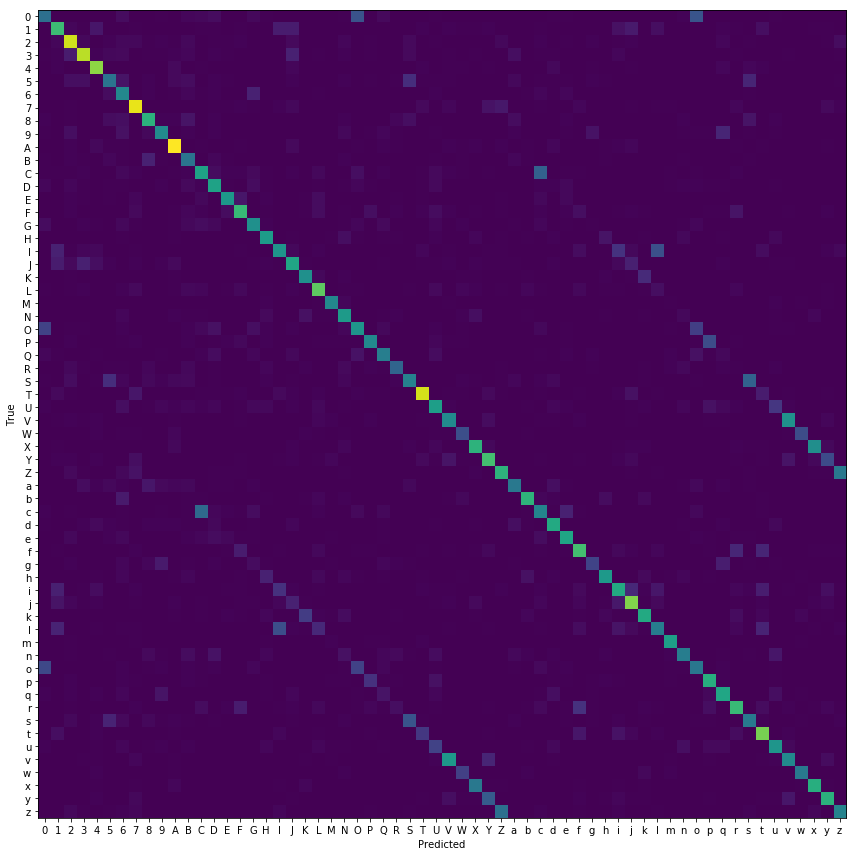

In [26]:
unique_val = list(y_train.unique())
unique_val.sort()
cm = confusion_matrix(y_test, y_pred, labels= unique_val )

plt.figure(figsize=(12,20))
plt.imshow(cm)

tick_marks = np.arange(len(unique_val))
plt.xticks(tick_marks, unique_val)
plt.yticks(tick_marks, unique_val)

plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()

### Porównanie najczęściej błędnie klasyfikowanych liter

In [30]:
lista = []
for i,val in enumerate(cm):
    for j,val1 in enumerate(cm[i]):
    if j != i:
        if cm[i][j] > 30:
            lista.append([cm[i][j],unique_val[i],unique_val[j]])   

df_cm = pd.DataFrame(lista, columns=['ilosc','pred','true'])
df_cm =  df_cm.sort_values(by='ilosc', ascending=False)
print(df_cm)


    ilosc pred true
20     98    v    V
8      93    V    v
10     91    X    x
12     74    Z    z
22     74    x    X
24     68    z    Z
13     63    c    C
7      58    S    s
2      57    C    c
23     53    y    Y
18     48    s    S
1      48    0    o
0      47    0    O
3      45    I    l
15     44    l    I
9      43    W    w
6      43    P    p
11     41    Y    y
16     40    o    0
17     36    o    O
19     36    u    U
4      36    O    0
21     35    w    W
5      34    O    o
14     33    k    K


### Miary oceny klasyfikatora dla poszczególnych klas

In [29]:
print(classification_report(y_test, y_pred, labels=unique_val))

              precision    recall  f1-score   support

           0       0.39      0.34      0.36       199
           1       0.56      0.57      0.56       222
           2       0.63      0.72      0.67       238
           3       0.75      0.67      0.71       246
           4       0.70      0.84      0.76       183
           5       0.47      0.41      0.44       174
           6       0.42      0.66      0.51       130
           7       0.70      0.75      0.73       236
           8       0.66      0.64      0.65       184
           9       0.62      0.56      0.59       159
           A       0.75      0.83      0.79       223
           B       0.44      0.63      0.52       112
           C       0.48      0.47      0.48       224
           D       0.56      0.66      0.61       160
           E       0.75      0.70      0.73       140
           F       0.65      0.61      0.63       203
           G       0.57      0.63      0.60       147
           H       0.62    

# 5. Podsumowanie

### Skuteczność modelu wydaje się dość obiecująca jednak trzeba wziąć pod uwagę jakość uczącego zbioru danych. W prawdziwych zastosowaniach jakość liter na zdjęciach czy skanach nie jest już tak idealna. Istnieje jednak sporo algorytmów filtrujących, czyszczących i wyrównujacych obrazy do postaci zbliżonej do analizowanych w projekcie. 

### Trzeba również zaznaczyć iż użycie miary podobieństwa do litery wzorcowej mogło ograniczyć w pewnym stopniu skuteczność uogólniania modelu oraz jego uniwersalności. Ze względu jednak na dużą ilość nieczytelnych czcionek zdecydowałem się zwiększyć skuteczność modelu dla standardowych czcionek używanych w znacznej większości przypadków.

### Kolejnym krokiem rozwoju projektu będzie zastosowanie metod pakietu OpenCV oraz kolejnego modelu głębokiego uczenia do rozpoznawania boxów z textem ze zdjęć oraz przetwarzanie samych już obiektów do pojedynczych obrazów liter. Na tak przygotowanych obiektach możliwe już będzie użycie zaprezentowanego modelu do predykcji a następnie łączenie liter w całe słowa.

